In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights, ResNet18_Weights
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix


In [2]:
class WheatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['healthy', 'sick']
        self.image_paths = []
        self.labels = []

        if not os.path.exists(root_dir):
            raise ValueError(f"Directory {root_dir} does not exist!")
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} not found, skipping...")
                continue
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg', '.jfif')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

        if len(self.image_paths) == 0:
            raise ValueError(f"No valid images found in {root_dir}!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')  # Исправлено Image -> image

            if self.transform:
                image = self.transform(image)  # Image -> image
            
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None


In [3]:
dataset = '/kaggle/input/wheatdataset/dataset/HealthySickWheat'
train_dir = '/kaggle/input/wheatdataset/dataset/HealthySickWheat/train'
test_dir = '/kaggle/input/wheatdataset/dataset/HealthySickWheat/test'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),     
    transforms.ToTensor(),              
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WheatDataset(root_dir=train_dir, transform = train_transforms)
test_dataset = WheatDataset(root_dir=train_dir, transform = test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32 ,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32 ,shuffle=False)

In [17]:
resnet50_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Sequential(
    nn.BatchNorm1d(num_features),  # Добавляем Batch Normalization
    nn.Linear(num_features, 512),  # Дополнительный слой (можно убрать)
    nn.ReLU(),                      # Активация
    nn.Linear(512, 2)               # Выходной слой для 2 классов
)

resnet18_model = models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
resnet18_model.fc = torch.nn.Linear(resnet18_model.fc.in_features, 2)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
resnet50_model.to(device)
resnet18_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)


In [28]:
def Train(model, dataloader, criterion, optimizer, epochs, device):
    model.train()

    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0
        correct = 0 
        total = 0
        for inputs, labels in tqdm(dataloader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuarcy: {epoch_acc:.2f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()

    plt.show()

In [29]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Сохраняем предсказания и истинные метки для матрицы ошибок
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    print(f'Evaluate: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%')

    # Построение матрицы ошибок
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


**Train Resnet18 model**

Epoch: 1/100, Loss: 0.8318, Accuarcy: 37.79


Epoch: 2/100, Loss: 0.8405, Accuarcy: 37.59


Epoch: 3/100, Loss: 0.8345, Accuarcy: 37.12


Epoch: 4/100, Loss: 0.8295, Accuarcy: 37.39


Epoch: 5/100, Loss: 0.8301, Accuarcy: 37.12


Epoch: 6/100, Loss: 0.8379, Accuarcy: 36.92


Epoch: 7/100, Loss: 0.8362, Accuarcy: 37.06


Epoch: 8/100, Loss: 0.8390, Accuarcy: 36.92


Epoch: 9/100, Loss: 0.8376, Accuarcy: 36.79


Epoch: 10/100, Loss: 0.8305, Accuarcy: 38.60


Epoch: 11/100, Loss: 0.8356, Accuarcy: 36.19


Epoch: 12/100, Loss: 0.8350, Accuarcy: 38.06


Epoch: 13/100, Loss: 0.8267, Accuarcy: 37.12


Epoch: 14/100, Loss: 0.8315, Accuarcy: 37.39


Epoch: 15/100, Loss: 0.8368, Accuarcy: 36.72


Epoch: 16/100, Loss: 0.8306, Accuarcy: 37.66


Epoch: 17/100, Loss: 0.8257, Accuarcy: 38.33


Epoch: 18/100, Loss: 0.8326, Accuarcy: 38.06


Epoch: 19/100, Loss: 0.8296, Accuarcy: 37.12


Epoch: 20/100, Loss: 0.8279, Accuarcy: 37.46


Epoch: 21/100, Loss: 0.8286, Accuarcy: 36.45


Epoch: 22/100, Loss: 0.8345, Accuarcy: 37.79


Epoch: 23/100, Loss: 0.8397, Accuarcy: 36.39


Epoch: 24/100, Loss: 0.8213, Accuarcy: 39.80


Epoch: 25/100, Loss: 0.8264, Accuarcy: 37.99


Epoch: 26/100, Loss: 0.8417, Accuarcy: 37.93


Epoch: 27/100, Loss: 0.8378, Accuarcy: 36.86


Epoch: 28/100, Loss: 0.8325, Accuarcy: 37.19


Epoch: 29/100, Loss: 0.8264, Accuarcy: 38.60


Epoch: 30/100, Loss: 0.8381, Accuarcy: 36.92


Epoch: 31/100, Loss: 0.8334, Accuarcy: 37.86


Epoch: 32/100, Loss: 0.8436, Accuarcy: 37.59


Epoch: 33/100, Loss: 0.8380, Accuarcy: 37.19


Epoch: 34/100, Loss: 0.8284, Accuarcy: 37.93


Epoch: 35/100, Loss: 0.8390, Accuarcy: 37.53


Epoch: 36/100, Loss: 0.8394, Accuarcy: 35.38


Epoch: 37/100, Loss: 0.8367, Accuarcy: 36.66


Epoch: 38/100, Loss: 0.8412, Accuarcy: 36.05


Epoch: 39/100, Loss: 0.8377, Accuarcy: 36.72


Epoch: 40/100, Loss: 0.8409, Accuarcy: 37.39


Epoch: 41/100, Loss: 0.8334, Accuarcy: 36.86


Epoch: 42/100, Loss: 0.8332, Accuarcy: 37.93


Epoch: 43/100, Loss: 0.8256, Accuarcy: 37.79


Epoch: 44/100, Loss: 0.8397, Accuarcy: 36.45


Epoch: 45/100, Loss: 0.8369, Accuarcy: 36.66


Epoch: 46/100, Loss: 0.8347, Accuarcy: 37.59


Epoch: 47/100, Loss: 0.8241, Accuarcy: 39.73


Epoch: 48/100, Loss: 0.8305, Accuarcy: 39.53


Epoch: 49/100, Loss: 0.8318, Accuarcy: 39.20


Epoch: 50/100, Loss: 0.8364, Accuarcy: 36.32


Epoch: 51/100, Loss: 0.8289, Accuarcy: 38.86


Epoch: 52/100, Loss: 0.8320, Accuarcy: 39.00


Epoch: 53/100, Loss: 0.8286, Accuarcy: 38.13


Epoch: 54/100, Loss: 0.8398, Accuarcy: 36.79


Epoch: 55/100, Loss: 0.8316, Accuarcy: 37.53


Epoch: 56/100, Loss: 0.8360, Accuarcy: 36.12


Epoch: 57/100, Loss: 0.8303, Accuarcy: 38.33


Epoch: 58/100, Loss: 0.8358, Accuarcy: 36.99


Epoch: 59/100, Loss: 0.8401, Accuarcy: 36.66


Epoch: 60/100, Loss: 0.8321, Accuarcy: 37.93


Epoch: 61/100, Loss: 0.8281, Accuarcy: 36.99


Epoch: 62/100, Loss: 0.8337, Accuarcy: 36.66


Epoch: 63/100, Loss: 0.8357, Accuarcy: 37.59


Epoch: 64/100, Loss: 0.8447, Accuarcy: 35.92


Epoch: 65/100, Loss: 0.8240, Accuarcy: 38.93


Epoch: 66/100, Loss: 0.8318, Accuarcy: 38.13


Epoch: 67/100, Loss: 0.8345, Accuarcy: 36.72


Epoch: 68/100, Loss: 0.8345, Accuarcy: 38.06


Epoch: 69/100, Loss: 0.8389, Accuarcy: 37.12


Epoch: 70/100, Loss: 0.8355, Accuarcy: 36.52


Epoch: 71/100, Loss: 0.8326, Accuarcy: 37.06


Epoch: 72/100, Loss: 0.8394, Accuarcy: 37.46


Epoch: 73/100, Loss: 0.8363, Accuarcy: 37.66


Epoch: 74/100, Loss: 0.8395, Accuarcy: 37.53


Epoch: 75/100, Loss: 0.8321, Accuarcy: 38.33


Epoch: 76/100, Loss: 0.8413, Accuarcy: 36.72


Epoch: 77/100, Loss: 0.8313, Accuarcy: 39.87


Epoch: 78/100, Loss: 0.8291, Accuarcy: 37.66


Epoch: 79/100, Loss: 0.8369, Accuarcy: 38.26


Epoch: 80/100, Loss: 0.8300, Accuarcy: 37.66


Epoch: 81/100, Loss: 0.8311, Accuarcy: 37.12


Epoch: 82/100, Loss: 0.8320, Accuarcy: 37.46


Epoch: 83/100, Loss: 0.8243, Accuarcy: 37.73


Epoch: 84/100, Loss: 0.8318, Accuarcy: 37.79


Epoch: 85/100, Loss: 0.8384, Accuarcy: 37.53


Epoch: 86/100, Loss: 0.8298, Accuarcy: 37.93


Epoch: 87/100, Loss: 0.8346, Accuarcy: 36.66


Epoch: 88/100, Loss: 0.8414, Accuarcy: 36.39


Epoch: 89/100, Loss: 0.8293, Accuarcy: 37.39


Epoch: 90/100, Loss: 0.8301, Accuarcy: 37.59


Epoch: 91/100, Loss: 0.8292, Accuarcy: 38.86


Epoch: 92/100, Loss: 0.8338, Accuarcy: 37.12


Epoch: 93/100, Loss: 0.8323, Accuarcy: 38.13


Epoch: 94/100, Loss: 0.8312, Accuarcy: 37.99


Epoch: 95/100, Loss: 0.8286, Accuarcy: 37.66


Epoch: 96/100, Loss: 0.8299, Accuarcy: 37.86


Epoch: 97/100, Loss: 0.8286, Accuarcy: 38.53


Epoch: 98/100, Loss: 0.8406, Accuarcy: 37.39


Epoch: 99/100, Loss: 0.8313, Accuarcy: 38.19


Epoch: 100/100, Loss: 0.8236, Accuarcy: 39.00


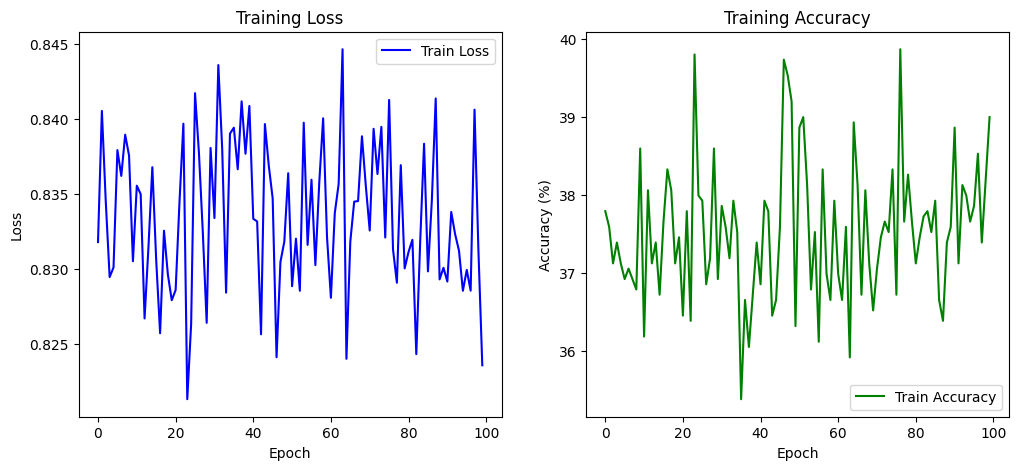

In [10]:
Train(resnet18_model, train_loader, criterion , optimizer, 100, device)

**Train Resnet50 model**

Epoch: 1/100, Loss: 0.3557, Accuarcy: 85.48


Epoch: 2/100, Loss: 0.2672, Accuarcy: 89.70


Epoch: 3/100, Loss: 0.1432, Accuarcy: 95.32


Epoch: 4/100, Loss: 0.1103, Accuarcy: 96.52


Epoch: 5/100, Loss: 0.0912, Accuarcy: 96.86


Epoch: 6/100, Loss: 0.0984, Accuarcy: 95.99


Epoch: 7/100, Loss: 0.0730, Accuarcy: 97.46


Epoch: 8/100, Loss: 0.0595, Accuarcy: 98.19


Epoch: 9/100, Loss: 0.0523, Accuarcy: 98.26


Epoch: 10/100, Loss: 0.0592, Accuarcy: 97.99


Epoch: 11/100, Loss: 0.0413, Accuarcy: 98.60


Epoch: 12/100, Loss: 0.0507, Accuarcy: 98.19


Epoch: 13/100, Loss: 0.0447, Accuarcy: 98.46


Epoch: 14/100, Loss: 0.0387, Accuarcy: 98.26


Epoch: 15/100, Loss: 0.0525, Accuarcy: 98.66


Epoch: 16/100, Loss: 0.0461, Accuarcy: 98.33


Epoch: 17/100, Loss: 0.0364, Accuarcy: 98.93


Epoch: 18/100, Loss: 0.0267, Accuarcy: 98.86


Epoch: 19/100, Loss: 0.0318, Accuarcy: 98.93


Epoch: 20/100, Loss: 0.0214, Accuarcy: 99.06


Epoch: 21/100, Loss: 0.0149, Accuarcy: 99.60


Epoch: 22/100, Loss: 0.0113, Accuarcy: 99.53


Epoch: 23/100, Loss: 0.0098, Accuarcy: 99.46


Epoch: 24/100, Loss: 0.0223, Accuarcy: 99.20


Epoch: 25/100, Loss: 0.0378, Accuarcy: 98.73


Epoch: 26/100, Loss: 0.0347, Accuarcy: 98.80


Epoch: 27/100, Loss: 0.0496, Accuarcy: 98.33


Epoch: 28/100, Loss: 0.0234, Accuarcy: 99.06


Epoch: 29/100, Loss: 0.0470, Accuarcy: 98.33


Epoch: 30/100, Loss: 0.0455, Accuarcy: 98.19


Epoch: 31/100, Loss: 0.0656, Accuarcy: 97.99


Epoch: 32/100, Loss: 0.1067, Accuarcy: 96.59


Epoch: 33/100, Loss: 0.0470, Accuarcy: 98.53


Epoch: 34/100, Loss: 0.0433, Accuarcy: 98.39


Epoch: 35/100, Loss: 0.0415, Accuarcy: 98.39


Epoch: 36/100, Loss: 0.0388, Accuarcy: 98.66


Epoch: 37/100, Loss: 0.0284, Accuarcy: 99.06


Epoch: 38/100, Loss: 0.0190, Accuarcy: 99.33


Epoch: 39/100, Loss: 0.0264, Accuarcy: 98.93


Epoch: 40/100, Loss: 0.0207, Accuarcy: 99.06


Epoch: 41/100, Loss: 0.0306, Accuarcy: 98.93


Epoch: 42/100, Loss: 0.0234, Accuarcy: 98.93


Epoch: 43/100, Loss: 0.0244, Accuarcy: 99.06


Epoch: 44/100, Loss: 0.0300, Accuarcy: 98.66


Epoch: 45/100, Loss: 0.0165, Accuarcy: 99.26


Epoch: 46/100, Loss: 0.0158, Accuarcy: 99.33


Epoch: 47/100, Loss: 0.0153, Accuarcy: 99.33


Epoch: 48/100, Loss: 0.0365, Accuarcy: 98.93


Epoch: 49/100, Loss: 0.0200, Accuarcy: 99.20


Epoch: 50/100, Loss: 0.0215, Accuarcy: 99.13


Epoch: 51/100, Loss: 0.0240, Accuarcy: 98.93


Epoch: 52/100, Loss: 0.0250, Accuarcy: 99.06


Epoch: 53/100, Loss: 0.0312, Accuarcy: 99.06


Epoch: 54/100, Loss: 0.0194, Accuarcy: 99.13


Epoch: 55/100, Loss: 0.0167, Accuarcy: 99.40


Epoch: 56/100, Loss: 0.0177, Accuarcy: 99.33


Epoch: 57/100, Loss: 0.0208, Accuarcy: 99.20


Epoch: 58/100, Loss: 0.0202, Accuarcy: 99.26


Epoch: 59/100, Loss: 0.0188, Accuarcy: 99.33


Epoch: 60/100, Loss: 0.0113, Accuarcy: 99.46


Epoch: 61/100, Loss: 0.0105, Accuarcy: 99.53


Epoch: 62/100, Loss: 0.0100, Accuarcy: 99.53


Epoch: 63/100, Loss: 0.0099, Accuarcy: 99.53


Epoch: 64/100, Loss: 0.0102, Accuarcy: 99.53


Epoch: 65/100, Loss: 0.0110, Accuarcy: 99.46


Epoch: 66/100, Loss: 0.0097, Accuarcy: 99.53


Epoch: 67/100, Loss: 0.0091, Accuarcy: 99.60


Epoch: 68/100, Loss: 0.0098, Accuarcy: 99.46


Epoch: 69/100, Loss: 0.0092, Accuarcy: 99.60


Epoch: 70/100, Loss: 0.0098, Accuarcy: 99.53


Epoch: 71/100, Loss: 0.0125, Accuarcy: 99.40


Epoch: 72/100, Loss: 0.0246, Accuarcy: 99.26


Epoch: 73/100, Loss: 0.0123, Accuarcy: 99.46


Epoch: 74/100, Loss: 0.0495, Accuarcy: 98.19


Epoch: 75/100, Loss: 0.0317, Accuarcy: 98.86


Epoch: 76/100, Loss: 0.0479, Accuarcy: 98.60


Epoch: 77/100, Loss: 0.0207, Accuarcy: 99.20


Epoch: 78/100, Loss: 0.0149, Accuarcy: 99.46


Epoch: 79/100, Loss: 0.0136, Accuarcy: 99.33


Epoch: 80/100, Loss: 0.0182, Accuarcy: 99.33


Epoch: 81/100, Loss: 0.0234, Accuarcy: 99.13


Epoch: 82/100, Loss: 0.0155, Accuarcy: 99.33


Epoch: 83/100, Loss: 0.0143, Accuarcy: 99.40


Epoch: 84/100, Loss: 0.0129, Accuarcy: 99.40


Epoch: 85/100, Loss: 0.0162, Accuarcy: 99.46


Epoch: 86/100, Loss: 0.0106, Accuarcy: 99.46


Epoch: 87/100, Loss: 0.0140, Accuarcy: 99.20


Epoch: 88/100, Loss: 0.0108, Accuarcy: 99.53


Epoch: 89/100, Loss: 0.0107, Accuarcy: 99.46


Epoch: 90/100, Loss: 0.0113, Accuarcy: 99.53


Epoch: 91/100, Loss: 0.0110, Accuarcy: 99.46


Epoch: 92/100, Loss: 0.0103, Accuarcy: 99.53


Epoch: 93/100, Loss: 0.0095, Accuarcy: 99.53


Epoch: 94/100, Loss: 0.0093, Accuarcy: 99.53


Epoch: 95/100, Loss: 0.0092, Accuarcy: 99.53


Epoch: 96/100, Loss: 0.0096, Accuarcy: 99.53


Epoch: 97/100, Loss: 0.0095, Accuarcy: 99.53


Epoch: 98/100, Loss: 0.0094, Accuarcy: 99.53


Epoch: 99/100, Loss: 0.0097, Accuarcy: 99.53


Epoch: 100/100, Loss: 0.0093, Accuarcy: 99.53


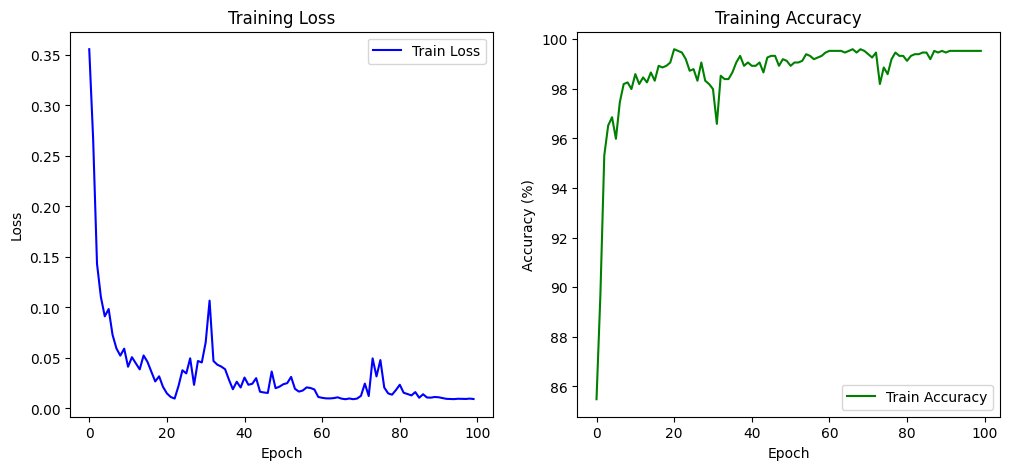

In [32]:
Train(resnet50_model, train_loader, criterion , optimizer, 100, device)

In [ ]:
evaluate(model, test_loader, criterion, device)

In [35]:
torch.save(resnet50_model.state_dict(), "resnet50_model.pth")
print("Модель сохранена!")


Модель сохранена!


In [39]:
torch.save(resnet18_model.state_dict(), "resnet18_model.pth")
print("Модель сохранена!")

Модель сохранена!
